### Here, we combine the training data from the four states WI, MA, GA and NC and create a combined model
- We consider the OLS linear regression, Adaboost, Random forest and xgboost models.
- We also perform some hyperparameter tuning on the xgboost model.
- The best hyperparameters: n_estimators = 800, max_depth = 3 and learning_rate = 0.1
- We do PCA with n-components=0.95 to this hyperparameter tuned model to create another model.
- PCA(n-components=0.95) reduces 17 features to 9 principal components
### Summarizing RMSE's on 5-Fold cross-validation of the various models:
- Baseline ("take average and call it a day" model): 19.435566170780614
- OLS linear regression (sklearn): 14.559055991158607
- Adaboost model (sklearn): 12.906395048789772
- Random forest model (sklearn): 10.953117282796535
- Xgboost model (w/o hyperparameter tuning): 10.699680617050998
- Xgboost model (with hyperparameter tuning): 10.315455038470585
- Xgboost model (hyperparameter tuning + PCA): 10.577576425033437
### Summarizing R-squared score on 5-fold cross-validation of the various models
- Baseline ("take average and call it a day" model): -0.0039697246545322695
- OLS linear regression (sklearn): 0.43643944317214933
- Adaboost model (sklearn): 0.5571093080817437
- Random forest model (sklearn): 0.6807484011328917
- Xgboost model (w/o hyperparameter tuning): 0.695064708859438
- Xgboost model (with hyperparameter tuning): 0.7165536140697122
- Xgboost model (hyperparameter tuning + PCA): 0.7024763474801394
### Top five features according to SHAP, with their mean |SHAP_value| on the hyperparameters tuned xgboost model:
- Per capita income: 12.272074
- closest_five_landgrnt_avg: 2.458358
- Population: 2.347372
- closest_five_public_avg: 1.697704
- closest_five_private_nfp_avg: 1.687542

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [111]:
wi_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
ma_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
ga_training = pd.read_pickle('data/GA_pickled/training.pkl')
nc_training = pd.read_csv('data/North_Carolina/train_test_split/training.csv')

In [112]:
features = list(wi_training.columns[9:])
relevantcolumns = ['COUNTY','PERCENT_3_OR_ABOVE']+features
len(relevantcolumns)

19

In [113]:
ga_training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'},inplace=True)

In [114]:
nc_training.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [115]:
wi_training=wi_training[relevantcolumns]
ma_training=ma_training[relevantcolumns]
ga_training=ga_training[relevantcolumns]
nc_training=nc_training[relevantcolumns]

In [116]:
nc_training=nc_training[nc_training['PERCENT_3_OR_ABOVE'] != '*']

In [117]:
nc_training=nc_training.dropna()

In [118]:
training = pd.concat([wi_training,ma_training,ga_training,nc_training],axis=0)

In [119]:
training = training.apply(pd.to_numeric, errors='coerce')

In [120]:
training

,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,NaN,58.508604,65586.0,52266.0,102.934660,49.119866,54.126134,149.798787,93.728419,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,NaN,42.187500,16631.0,42307.0,93.067423,37.142154,30.704517,165.243556,91.579850,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,NaN,59.333333,23688.0,49996.0,96.378027,36.954639,42.626467,159.078732,94.292621,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,NaN,75.934136,90998.0,83681.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,NaN,68.906752,91613.0,86875.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,70.000000,19383.0,54915.0,137.926921,28.720862,37.577446,183.704575,137.926921,30033.8,5018.6,1433.2,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8
224,NaN,69.512195,33046.0,48333.0,131.307585,38.818306,40.054315,178.329454,131.307585,30916.8,6888.4,2391.2,24107.2,30916.8,6860.6,910.4,1802.2,6481.0,6860.6
227,NaN,65.241295,227214.0,49313.0,91.741941,29.883256,24.596159,183.714823,91.741941,22496.4,15354.6,872.0,24885.2,22496.4,6242.6,1207.8,524.6,6909.0,6242.6
228,NaN,56.060606,99799.0,40777.0,129.024685,33.206873,39.224774,197.321227,129.024685,25475.8,4846.0,2406.8,24107.2,25475.8,5874.8,0.0,835.4,6481.0,5874.8


In [121]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [122]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

N_CORES = joblib.cpu_count(only_physical_cores=True)

In [123]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(train_data[features], train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], ada_reg.predict(holdout_data[features]))
    rsquared[1, i] = ada_reg.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Foret model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))

    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    full_lr.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[4, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], full_lr.predict(holdout_data[features]))
    rsquared[4, i] = full_lr.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    

    i = i+1


[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[160]	train-rmse:4.57308	validation-rmse:11.31545
[0]	train-rmse:16.07849	validation-rmse:16.27813
[10]	train-rmse:7.82496	validation-rmse:11.26908
[20]	train-rmse:6.76132	validation-rmse:10.80602
[30]	train-rm

In [124]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[1,:])}")

Baseline Avg. CV RMSE: 19.435566170780614 and STD: 0.28983035684433756
Adaboost model Avg. CV RMSE: 12.906395048789772 and STD: 0.4282853711378811
xgboost model Avg. CV RMSE: 10.699680617050998 and STD: 0.5275075418050919
Random forest model Avg. CV RMSE: 10.953117282796535 and STD: 0.4756653725105333
fullmodel Avg. CV RMSE: 14.559055991158607 and STD: 0.4282853711378811


In [125]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[4,:])} and STD: {np.std(rsquared[1,:])}")

Baseline Avg. CV score: -0.0039697246545322695 and STD: 0.005332962004680793
Adaboost Avg. CV score: 0.5571093080817437 and STD: 0.022415697948725076
Xgboost model Avg. CV score: 0.695064708859438 and STD: 0.028113712661615817
Random forest model Avg. CV score: 0.6807484011328918 and STD: 0.024339603398400415
fullmodel Avg. CV score: 0.43643944317214933 and STD: 0.022415697948725076


### Xgboost works the best on the combined model. But random forest is not far behind.

In [126]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [127]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 800

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_old_model = xgb.train(
params=params,
dtrain=dtrain_reg,
num_boost_round=n,
evals=evals,
verbose_eval=10,            # Print rmse val every 10 rounds
early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)
## This model is created before any hyperparameters tuning. So we name it as 'xgb_old_model'

[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358


# Hyperparameters tuning for xgboost model

In [128]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer

transformer = ColumnTransformer(transformers=[
    ('freq',PowerTransformer(method='box-cox', standardize=False),[0]),
    ('chord', KBinsDiscretizer(n_bins = 6, encode='ordinal', strategy='kmeans'),[1] ),
    ('vel',KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='kmeans'),[2]),
    ('thickness',QuantileTransformer(),[3]),
    ],
    remainder='passthrough'
    )


In [129]:

hyperparameter_grid = {
    'model__n_estimators': [100, 400, 800, 1000],
    'model__max_depth': [3, 6, 9, 10],
    'model__learning_rate': [0.01,0.05, 0.1, 0.20],
    }

pipeline = RandomizedSearchCV(
    Pipeline(steps=[("preprocessor", transformer), 
                    ("model", xgb.XGBRegressor(objective= 'reg:squarederror',seed = 0))
                    ]),
    param_distributions=hyperparameter_grid,
    n_iter=20,
    scoring='r2',
    n_jobs=-1,
    cv=7,
    verbose=3)


In [130]:
pipeline.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
[CV 1/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.674 total time=   2.3s
[CV 6/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.768 total time=   2.5s
[CV 7/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.576 total time=   2.5s
[CV 2/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.606 total time=   2.4s
[CV 1/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=800;, score=0.674 total time=   2.3s
[CV 5/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.685 total time=   2.5s
[CV 3/7] END model__learning_rate=0.2, model__max_depth=10, model__n_estimators=1000;, score=0.680 total time=   2.7s
[CV 1/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100;, score=0.334 total time=   0

RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('freq',
                                                                               PowerTransformer(method='box-cox',
                                                                                                standardize=False),
                                                                               [0]),
                                                                              ('chord',
                                                                               KBinsDiscretizer(encode='ordinal',
                                                                                                n_bins=6,
                                                                                                strategy='kmeans'),
                                                                               [1]),
                                                                              ('vel',
                                                                               KBinsDiscretizer(encode='ordinal',
                                                                                                n_bins=4,
                                                                                                strategy='kmeans'),
                                                                               [2]),
                                                                              ('thickness'...
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'model__max_depth': [3, 6, 9, 10],
                                        'model__n_estimators': [100, 400, 800,
                                                                1000]},
                   scoring='r2', verbose=3)

In [131]:
hyperparam = pipeline.best_params_
print("The best Hyperparameters for XGBRegressor are: {}".format(hyperparam))

The best Hyperparameters for XGBRegressor are: {'model__n_estimators': 800, 'model__max_depth': 3, 'model__learning_rate': 0.1}


# Next, let us see if PCA makes our model more efficient or if we drastically lose performance.

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [140]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(train[features])
training_scaled.shape

(1373, 17)

In [141]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)
training_pca.shape

(1373, 9)

In [142]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('xgb_model', xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror'))])

In [143]:
xgb_pca_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [144]:
xgb_pca_preds = xgb_pca_pipe.predict(validation[features])
print(root_mean_squared_error(xgb_pca_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_pca_preds,multioutput='variance_weighted'))

11.151306208340863
0.6739408003287407


In [145]:
xgb_new_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
xgb_new_model.fit(train[features],train['PERCENT_3_OR_ABOVE'])
xgb_new_preds = xgb_new_model.predict(validation[features])
print(root_mean_squared_error(xgb_new_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_new_preds,multioutput='variance_weighted'))

10.497967752155544
0.7110282127287335


In [146]:
xgb_old_preds = xgb_old_model.predict(dtest_reg)
print(root_mean_squared_error(xgb_old_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_old_preds,multioutput='variance_weighted'))

11.315453848208739
0.6642709430281344


### Our hyperparameter-tuned model is clearly better than the older model in terms of root mean squared error and the PCA(0.95) model is marginally ahead of our old model. Analogous conclusion can be obtained from the R-squared values.
### Let us further test with 5-Fold cross validation.

In [148]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for new hyperparameter tuned xgboost model
    xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
    xgb_model.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_model.predict(holdout_data[features]))
    xgb_preds = xgb_model.predict(holdout_data[features])
    rsquared[1, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'],xgb_preds)
    
    
    ## Fit and get ho mse for old (not hyperparameter tuned) xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_old_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_old_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred,multioutput='variance_weighted')

    
    ## Fit and get ho mse for xgb PCA(0.95) model with hyperparameter tuning
    xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror'))])
    xgb_pca_pipe.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))

    

    i = i+1

[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[160]	train-rmse:4.57308	validation-rmse:11.31545
[0]	train-rmse:16.07849	validation-rmse:16.27813
[10]	train-rmse:7.82496	validation-rmse:11.26908
[20]	train-rmse:6.76132	validation-rmse:10.80602
[30]	train-rm

In [149]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"Old xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.435566170780614 and STD: 0.28983035684433756
Hyperparameter tuned xgboost model Avg. CV RMSE: 10.315455038470585 and STD: 0.4791867256189401
Old xgboost model Avg. CV RMSE: 10.699680617050998 and STD: 0.5275075418050919
Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: 10.577576425033437 and STD: 0.4258530627799285


In [150]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Old Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.0039697246545322695 and STD: 0.005332962004680793
Hyperparameter tuned xgboost model Avg. CV score: 0.7165536140697122 and STD: 0.025459581675542808
Old Xgboost model Avg. CV score: 0.695064708859438 and STD: 0.028113712661615817
Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: 0.7024763474801394 and STD: 0.018538762288899415


### The hyperparameter tuned model is certainly the beest. But PCA(0.95) does not fall behind in performance by much.

### We save our new hyperparameters tuned xgboost model as a pickle file. This will serve as our final model for four states combined.

In [151]:
xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
xgb_model.fit(train[features],train['PERCENT_3_OR_ABOVE'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [155]:
import joblib
from joblib import Parallel, delayed

## Save the xgboost model as a pickled file.

#joblib.dump(xgb_model, 'data/four_states_combined_xgboost_model.pkl')

# SHAP to interpret our models and feature importance

In [161]:
import shap
import pickle

### Let's look at the hyperparameter tuned xgboost model

In [162]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [163]:
# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from SHAP:\n")
print(shap_importance)

Feature Importance from SHAP:

                                    Feature  Importance
1                         per_capita_income   12.272074
5                 closest_five_landgrnt_avg    2.458358
0                                population    2.347372
3                   closest_five_public_avg    1.697704
4              closest_five_private_nfp_avg    1.687542
12          closest_five_avg_dormrooms_r1r2    1.534790
10     closest_five_avg_enrollment_landgrnt    1.238524
9   closest_five_avg_enrollment_private_nfp    1.154520
7          closest_five_avg_enrollment_r1r2    1.094318
14   closest_five_avg_dormrooms_private_nfp    1.065784
2                     closest_five_r1r2_avg    1.009365
8        closest_five_avg_enrollment_public    0.967761
6                     closest_five_stem_avg    0.753971
16          closest_five_avg_dormrooms_stem    0.724050
11         closest_five_avg_enrollment_stem    0.671008
13        closest_five_avg_dormrooms_public    0.604561
15     closest_fi

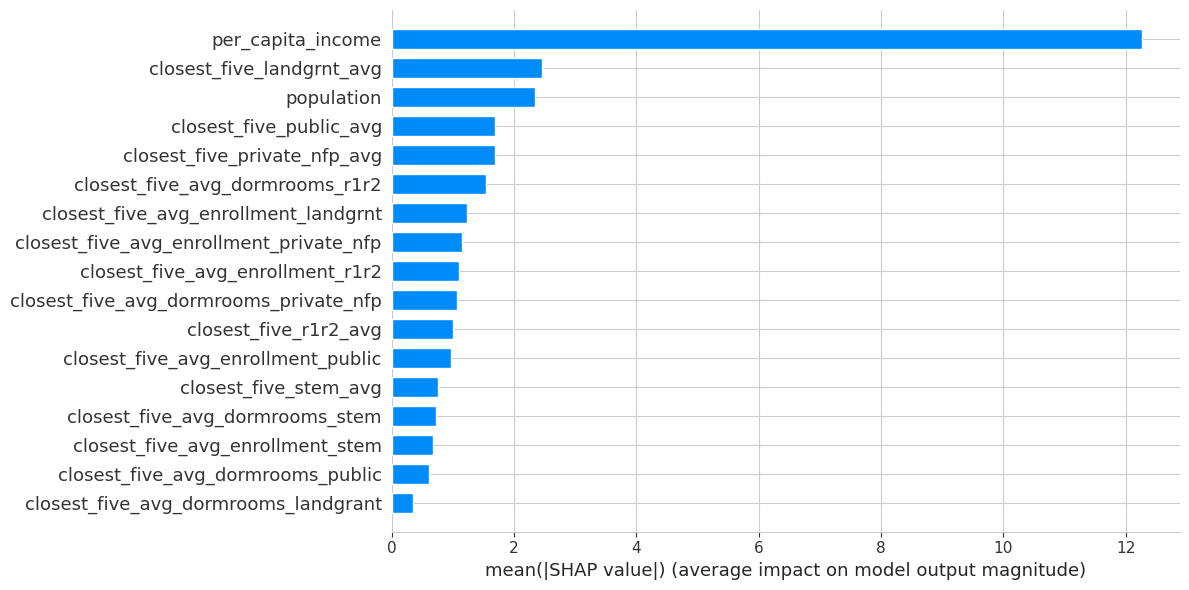

In [166]:
fig = plt.figure()
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_bar_plot.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.close()

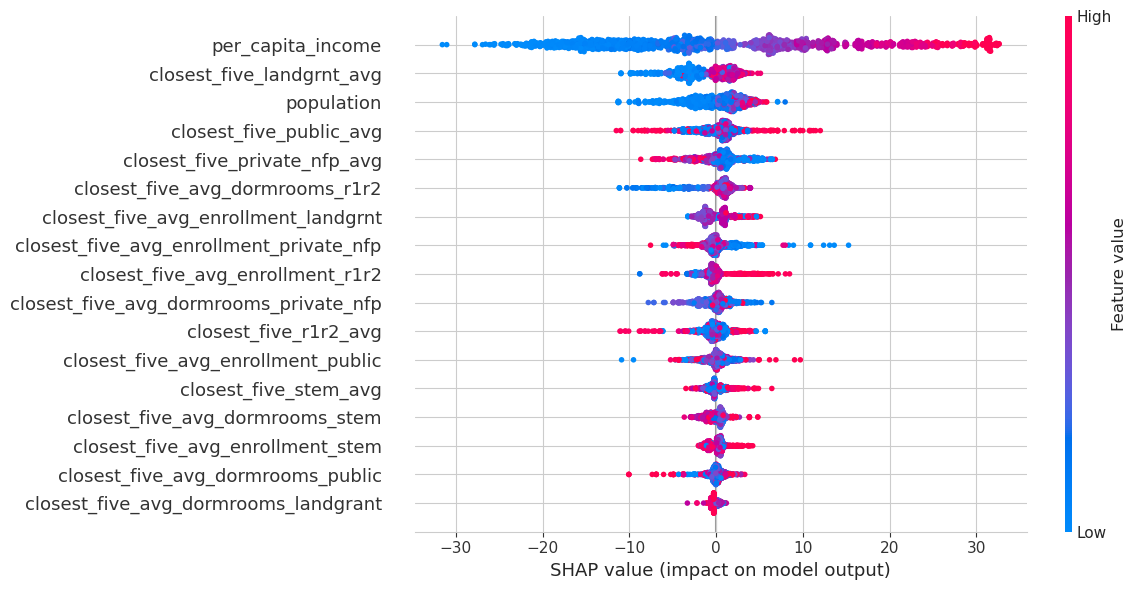

In [167]:
### the scatter plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_scatter_plot.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.close()